In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def parse_history_output(filename):
    with open(filename, "r", encoding="utf-8") as file:
        content = file.read()

    # Regex to capture blocks
    pattern = re.compile(r'History output component, gradient\.(\S+)(.*?)End component', re.DOTALL)

    blocks = {}
    for match in pattern.finditer(content):
        block_name = match.group(1)  # Extracts block identifier (e.g., "NDTEMP.T", "COORDINATES.X")
        block_data = match.group(2).strip()  # Extracts data between header and "End component"
        blocks[block_name] = block_data  # Store in dictionary

    return blocks

def extract_numeric_data(block_content):
    """
    Extracts time and value pairs from a block of text.
    Returns a list of (time, value) tuples.
    """
    lines = block_content.split("\n")[1:]  # Skip the header line
    data = []
    # print(lines)
    for line in lines:
        parts = line.split(",")
        for i in range(1, len(parts)):
            try:
                time = float(parts[0].strip())
                value = float(parts[i].strip())
                data.append((time, value))
            except ValueError:
                pass  # Ignore invalid lines
    return data

def construct_dataframe(blocks):
    """
    Constructs a DataFrame from extracted blocks.
    Assumes all blocks share the same time steps.
    """
    data_dict = {}

    for key, block_content in blocks.items():
        parsed_data = extract_numeric_data(block_content)
        if parsed_data:
            times, values = zip(*parsed_data)  # Separate times and values
            if "Time" not in data_dict:  # Store time column once
                data_dict["Time"] = times
            data_dict[key] = values  # Store extracted values

    df = pd.DataFrame(data_dict)
    return df

def assign_node_ids(df):
    """
    Assigns a unique Node ID to each row based on its order of appearance
    in the first time step.
    """
    # Sort by Time and reset index to ensure order is consistent
    df = df.sort_values(by=["Time", "COORDINATES.X", "COORDINATES.Y", "COORDINATES.Z"]).reset_index(drop=True)

    # Identify unique nodes in the first time step
    first_time = df["Time"].min()
    first_timestep_nodes = df[df["Time"] == first_time][["COORDINATES.X", "COORDINATES.Y", "COORDINATES.Z"]].drop_duplicates().reset_index(drop=True)
    first_timestep_nodes["Node_ID"] = first_timestep_nodes.index + 1  # Assign IDs starting from 1

    # Merge Node IDs back into the main DataFrame
    df = df.merge(first_timestep_nodes, on=["COORDINATES.X", "COORDINATES.Y", "COORDINATES.Z"], how="left")

    # Reorder columns
    df = df[["Node_ID", "Time", "NDTEMP.T", "COORDINATES.X", "COORDINATES.Y", "COORDINATES.Z"]]

    return df

In [2]:
plt.style.use('https://raw.githubusercontent.com/dccote/Enseignement/master/SRC/dccote-basic.mplstyle')

In [ ]:
filename = "ProtoNouveau/2DRP5W.csv"
blocks = parse_history_output(filename)
df = construct_dataframe(blocks)
df = assign_node_ids(df)
# df.to_csv("2DRP5W_parsed")

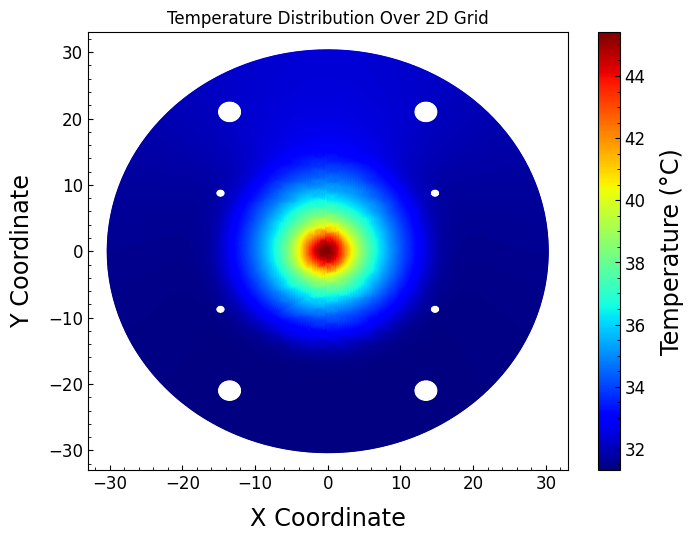

In [13]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(df["COORDINATES.X"], df["COORDINATES.Y"], c=df["NDTEMP.T"], cmap="jet", s=10)
plt.colorbar(sc, label="Temperature (°C)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Temperature Distribution Over 2D Grid")
plt.show()


In [4]:
filenames = ["ProtoNouveau/Final10W.csv", "ProtoNouveau/Final7.5W.csv", "ProtoNouveau/Final5W.csv", "ProtoNouveau/Final2.5W.csv"]
labels = ["10W", "7.5W", "5W", "2.5W"]
for i, filename in enumerate(filenames):
    parsed_blocks = parse_history_output(filename)
    df = construct_dataframe(parsed_blocks)
    df_nodes = assign_node_ids(df)
    newname = filename[13:-4]+"_parsed.csv"
    df_nodes.to_csv(newname)

In [86]:
def find_node(df, v):
    negative_nodes = df[df["COORDINATES.Y"] < 0]
    r = -v * 30 
    closest_node = negative_nodes.iloc[(negative_nodes["COORDINATES.Y"] - r).abs().idxmin()]
    return closest_node

<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_4940/3195097846.py:25: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta T$ [$\degree$ C]", fontsize="large")


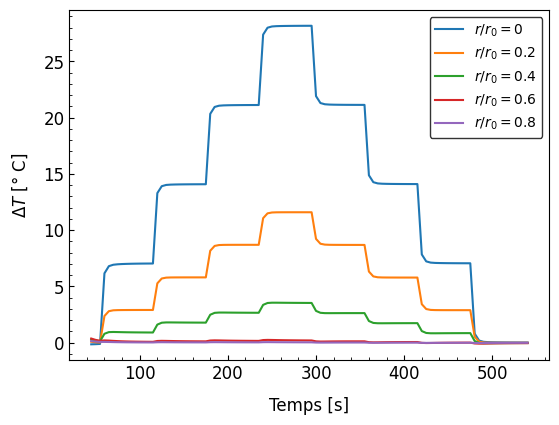

In [ ]:
filename = "ProtoNouveau/FinalStep.csv"
parsed_blocks = parse_history_output(filename)
df = construct_dataframe(parsed_blocks)
df_nodes = assign_node_ids(df)
hotspot = df_nodes[df_nodes["Node_ID"]==121]["NDTEMP.T"].to_numpy()
ailettes = df_nodes[df_nodes["Node_ID"]==241]
ailettesT = ailettes["NDTEMP.T"].to_numpy()
time = ailettes["Time"].to_numpy()
# print(max(hotspot["NDTEMP.T"]))
r02 = int(find_node(df_nodes, 0.2)["Node_ID"])
r04 = int(find_node(df_nodes, 0.4)["Node_ID"])
r06 = int(find_node(df_nodes, 0.6)["Node_ID"])
r08 = int(find_node(df_nodes, 0.8)["Node_ID"])
o2 = df_nodes[df_nodes["Node_ID"]==r02]["NDTEMP.T"].to_numpy()
o4 = df_nodes[df_nodes["Node_ID"]==r04]["NDTEMP.T"].to_numpy()
o6 = df_nodes[df_nodes["Node_ID"]==r06]["NDTEMP.T"].to_numpy()
o8 = df_nodes[df_nodes["Node_ID"]==r08]["NDTEMP.T"].to_numpy()
curves = [hotspot, o2, o4, o6, o8]
labels = [0, 0.2, 0.4, 0.6, 0.8]
for i, c in enumerate(curves):
    delta = c - ailettesT
    plt.plot(time[8:], delta[8:], label=f"$r/r_0={labels[i]}$")
    
plt.xlabel("Temps [s]", fontsize="large")
plt.ylabel("$\Delta T$ [$\degree$ C]", fontsize="large")
plt.legend()
# plt.savefig("ProtoNouveau/Step2.jpg",dpi=300)
plt.show()